## Calculate the fill factor for an LSST field of view.

Uses the camera geometry that is intended to represent the actual focal plane (or at least, one vendor's version of the focal plane geometry). 


In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

# For the footprint generation and conversion between galactic/equatorial coordinates.
from lsst.sims.utils import haversine, ObservationMetaData
from lsst.obs.lsstSim import LsstSimMapper
from lsst.sims.coordUtils import _observedFromICRS, _chipNameFromRaDec

import lsst.sims.utils as sims_utils

mapper = LsstSimMapper()
camera = mapper.camera
epoch = 2000.0
site = sims_utils.Site()

In [16]:
# Set up the observation metadata (boresight + time + rotator angle.)
fieldra = np.radians(10.0)
fielddec = np.radians(-30.0)
expmjd = 52999.96
alt, az, pa = sims_utils._altAzPaFromRaDec(fieldra, fielddec, site.longitude, site.latitude, expmjd)
print np.degrees(alt)

89.6652919262


In [17]:
rotskypos = np.radians(0.0)
obs_metadata = ObservationMetaData(unrefractedRA = np.degrees(fieldra),
                                   unrefractedDec = np.degrees(fielddec),
                                   rotSkyPos = np.degrees(rotskypos),
                                   mjd = expmjd)

In [31]:
# Set up points to iterate over (to calculate fill factor)
testrange = 2.2
spacing = 0.01
decscale = np.cos(fielddec)
decscale = 1.0
rai = np.arange(fieldra - np.radians(testrange)*decscale, 
                fieldra + np.radians(testrange)*decscale, np.radians(spacing)*decscale)
deci = np.arange(fielddec - np.radians(testrange), 
                 fielddec + np.radians(testrange), np.radians(spacing))
ra = []
dec = []
for i in itertools.product(rai, deci):
    ra.append(i[0])
    dec.append(i[1])
ra = np.array(ra)
dec = np.array(dec)

In [32]:
# Calculate 'visibility'
refractedra, refracteddec = _observedFromICRS(ra, dec, obs_metadata=obs_metadata, epoch=epoch)
chipNames = _chipNameFromRaDec(ra=refractedra, dec=refracteddec, epoch=epoch, 
                                camera=camera, obs_metadata=obs_metadata)
vis = np.zeros(len(chipNames))
for i, chip in enumerate(chipNames):
    if chip is not None:
        vis[i] = 1

In [33]:
# Calculate % fill factor, for a particular assumed (circular) fov

ra = refractedra
dec = refracteddec

fieldra, fielddec = _observedFromICRS(np.array([fieldra]), np.array([fielddec]), 
                                      obs_metadata=obs_metadata, epoch=epoch)
fieldra = fieldra[0]
fielddec = fielddec[0]

area_degsq = 9.6
innerradius = np.sqrt(area_degsq/np.pi)
print 'inner radius matching area_degsq for circle', innerradius
sep = np.degrees(sims_utils.haversine(ra, dec, fieldra, fielddec))
print 'max distance from center used for chip calculation', sep.max()
incircle = np.where(sep < innerradius)[0]
onchip = np.where(vis[incircle] == 1)[0]
fillfactor = len(vis[onchip]) / float(len(vis[incircle]))
print 'fill factor', fillfactor

area_degsq = 9.6
innerradius2 = 1.75
print 'inner radius matching area_degsq for circle', innerradius2
sep = np.degrees(sims_utils.haversine(ra, dec, fieldra, fielddec))
print 'max distance from center used for chip calculation', sep.max()
incircle = np.where(sep < innerradius2)[0]
onchip = np.where(vis[incircle] == 1)[0]
fillfactor = len(vis[onchip]) / float(len(vis[incircle]))
print 'fill factor', fillfactor

outerradius = 2.06
print 'outer radius', outerradius
sep = np.degrees(sims_utils.haversine(ra, dec, fieldra, fielddec))
print 'max distance from center used for chip calculation', sep.max()
incircle = np.where(sep < outerradius)[0]
onchip = np.where(vis[incircle] == 1)[0]
fillfactor = len(vis[onchip]) / float(len(vis[incircle]))
print 'fill factor', fillfactor

inner radius matching area_degsq for circle 1.74807748895
max distance from center used for chip calculation 2.92365701197
fill factor 0.887482520637
inner radius matching area_degsq for circle 1.75
max distance from center used for chip calculation 2.92365701197
fill factor 0.886891958781
outer radius 2.06
max distance from center used for chip calculation 2.92365701197
fill factor 0.729969773233


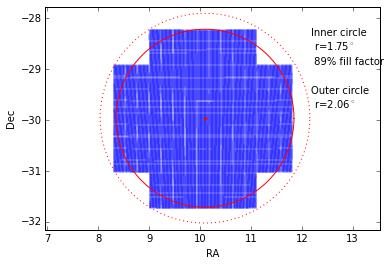

In [39]:
# Plot results.
plt.figure()
plt.axis('equal')
condition = np.where(vis == 1)[0]
# Use 'offset' so that plot doesn't cross 0
offset = 0
x = np.degrees((ra - fieldra)*np.cos(dec) + fieldra + offset) % 360
#plt.plot(x, np.degrees(dec), 'g.', markersize=0.2)
plt.plot(x[condition], np.degrees(dec[condition]), 'b.', markersize=0.3)
plt.plot(np.degrees(fieldra + offset), np.degrees(fielddec), 'r.')
plt.xlabel('RA')
plt.ylabel('Dec')
theta = np.arange(0, 2*np.pi, 0.01)
plt.plot(innerradius*np.cos(theta)+np.degrees(fieldra)+offset, innerradius*np.sin(theta)+np.degrees(fielddec), 'r-')
plt.plot(outerradius*np.cos(theta)+np.degrees(fieldra)+offset, outerradius*np.sin(theta)+np.degrees(fielddec), 'r:')
#plt.xlim(fieldra+offset-sep.max()/2.0, fieldra+offset+sep.max()/2.0)
plt.ylim(np.degrees(fielddec)-sep.max()*.75, np.degrees(fielddec)+sep.max()*.75)
x = 0.74
plt.figtext(x, 0.8, 'Inner circle')
plt.figtext(x, 0.75, r' r=1.75$^\circ$')
plt.figtext(x, 0.7, ' 89%s fill factor' %('%'))
plt.figtext(x, 0.6, 'Outer circle')
plt.figtext(x, 0.55, r' r=2.06$^\circ$')
#plt.figtext(x, 0.5, ' 71%s fill factor' %('%'))
plt.savefig('focalplane.png', format='png', dpi=600)

In [8]:
# zoom in to see a raft (ccd = 13', raft = 13*3 ' = 0.6 deg) in higher detail.
testrange = 0.5
spacing = 0.001
decscale = np.cos(fielddec)
rai = np.arange(fieldra - np.radians(testrange)*decscale, 
                fieldra + np.radians(testrange)*decscale, np.radians(spacing)*decscale)
deci = np.arange(fielddec - np.radians(testrange), 
                 fielddec + np.radians(testrange), np.radians(spacing))
ra = []
dec = []
for i in itertools.product(rai, deci):
    ra.append(i[0])
    dec.append(i[1])
ra = np.array(ra)
dec = np.array(dec)

# Calculate 'visibility'
refractedra, refracteddec = _observedFromICRS(ra, dec, obs_metadata=obs_metadata, epoch=epoch)
chipNames = _chipNameFromRaDec(ra=refractedra, dec=refracteddec, epoch=epoch, camera=camera, obs_metadata=obs_metadata)
vis = np.zeros(len(chipNames))
for i, chip in enumerate(chipNames):
    if chip is not None:
        vis[i] = 1

(-0.5, 0.5)

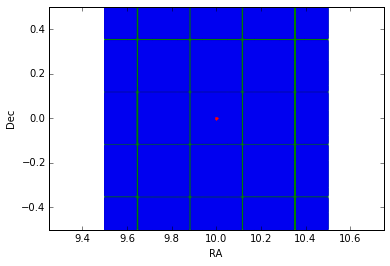

In [9]:
plt.figure()
plt.axis('equal')
condition = np.where(vis == 1)[0]
# Use 'offset' so that plot doesn't cross 0
offset = 0
plt.plot((np.degrees(ra)+offset)%360, np.degrees(dec), 'g.', markersize=0.2)
plt.plot((np.degrees(ra[condition])+offset)%360, np.degrees(dec[condition]), 'b.', markersize=0.3)
plt.plot(np.degrees(fieldra)+offset, np.degrees(fielddec), 'r.')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.xlim(9.5, 10.5)
plt.ylim(-.5, 0.5)

In [10]:
# And zoom in even more, to check raft/ccd spacing. Do single line in RA.
testrange = 2.0
spacing = 0.00005
decscale = np.cos(fielddec)
ra = np.arange(fieldra - np.radians(testrange)*decscale, 
                fieldra + np.radians(testrange)*decscale, np.radians(spacing)*decscale)
dec = np.zeros(len(ra)) + fielddec

# Calculate 'visibility'
refractedra, refracteddec = _observedFromICRS(ra, dec, obs_metadata=obs_metadata, epoch=epoch)
chipNames = _chipNameFromRaDec(ra=refractedra, dec=refracteddec, epoch=epoch, camera=camera, obs_metadata=obs_metadata)
vis = np.zeros(len(chipNames))
for i, chip in enumerate(chipNames):
    if chip is not None:
        vis[i] = 1

[ 797.58000001   44.1         798.12000001   45.36        798.84000001
   49.68        799.38000001   44.28        799.74000001   43.92
  799.92000001   51.3         799.92000001   44.82        799.92000001
   44.82        800.10000001   50.22        799.92000001   44.82
  799.74000001   43.74        799.38000001   49.86        798.84000001
   46.08        798.30000001   43.92        797.58000001]


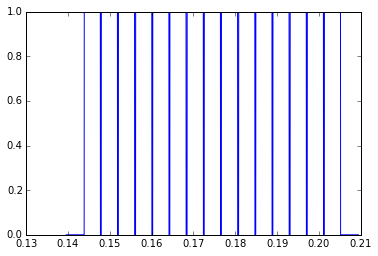

In [11]:
plt.plot(ra, vis)
condition = np.where(np.diff(vis) != 0)[0]
print np.diff(np.degrees(ra[condition])*60.*60.)

In [12]:
# I need to map the overall visibility back into a 100x100 grid for Peter.